In [375]:
import netCDF4
from osgeo import gdal
from osgeo import osr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import os
import re
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
# Helperfunction to calculate the number of days from the origin (1900-1-1 00:00:00)
def get_days(year, month, day, hour, minute = 0, second = 0, origin = datetime(1900, 1, 1, 0, 0, 0)):
    diff = datetime(year, month, day, hour, minute, second)-origin
    days = diff.days + (diff.seconds/24/3600)
    return(days)

In [376]:
all_nc = glob.glob("../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95//*.nc")

all_nc

['../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201601010000_201612310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201301010000_201312310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201801010000_201812310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201401010000_201412310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201101010000_201112310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201701010000_201712310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201501010000_201512310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201201010000_201212310000.nc',
 '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_202101010000_202112310000.nc',
 

In [377]:
tabs = glob.glob("../data/historische_daten/TabsD_2001_2021_LV95/*.nc")
tmax = glob.glob("../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/*.nc")

nc_per_year = {}
for year in range(2012, 2021):
    dict_per_year = {}
    dict_per_year["thisMean"] = [file for file in tabs if re.search(str(year)+"01010000_"+str(year)+"12310000", file)][0]     # slightly unsafe (if there are multiple matches)
    dict_per_year["nextMean"] = [file for file in tabs if re.search(str(year+1)+"01010000_"+str(year+1)+"12310000", file)][0] # slightly unsafe (if there are multiple matches)
    dict_per_year["thisMax"] = [file for file in tmax if re.search(str(year)+"01010000_"+str(year)+"12310000", file)][0]     # slightly unsafe (if there are multiple matches)
    dict_per_year["nextMax"] = [file for file in tmax if re.search(str(year+1)+"01010000_"+str(year+1)+"12310000", file)][0] # slightly unsafe (if there are multiple matches)
    nc_per_year[year] = dict_per_year
    
nc_per_year

{2012: {'thisMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201201010000_201212310000.nc',
  'nextMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'thisMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201201010000_201212310000.nc',
  'nextMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201301010000_201312310000.nc'},
 2013: {'thisMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'nextMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201401010000_201412310000.nc',
  'thisMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'nextMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201401010000_201412310000.nc'},
 2014: {'thisMean': '../data/h

In [378]:
tmean_2012 = netCDF4.Dataset(nc_per_year[2012]["thisMean"])
tmax_2012 = netCDF4.Dataset(nc_per_year[2012]["thisMax"])


In [379]:
# what dimensions does the netCDF file have?
tmean_2012.dimensions
tmax_2012.dimensions

# the shape of lon 370 cells (each **1**km) east-west, looks correct
# the shape of lat 240 cells (each **1**km) north-south, looks correct
# the shape of time 366 days, looks correct

{'E': <class 'netCDF4._netCDF4.Dimension'>: name = 'E', size = 370,
 'N': <class 'netCDF4._netCDF4.Dimension'>: name = 'N', size = 240,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 366}

In [380]:
# What variables does the dataset have?
tmean_2012.variables.keys()
tmax_2012.variables.keys()

dict_keys(['swiss_lv95_coordinates', 'E', 'N', 'time', 'TmaxD', 'lon', 'lat'])

In [381]:
# metadata on variable "tas"

tmean_2012.variables["TabsD"] # daily mean temperature


<class 'netCDF4._netCDF4.Variable'>
float32 TabsD(time, N, E)
    units: degree
    _FillValue: -999.99
    grid_mapping: swiss_lv95_coordinates
    coordinates: lon lat
    long_name: daily mean temperature
    grid_name: ch01r.swiss.lv95
    version: v1.2
    prod_date: 2021-09-08 04:42:56
unlimited dimensions: time
current shape = (366, 240, 370)
filling on

In [382]:
tmax_2012.variables["TmaxD"]  # daily maximum temperature


<class 'netCDF4._netCDF4.Variable'>
float32 TmaxD(time, N, E)
    units: degree
    _FillValue: -999.99
    grid_mapping: swiss_lv95_coordinates
    coordinates: lon lat
    long_name: daily maximum temperature
    grid_name: ch01r.swiss.lv95
    version: v1.2
    prod_date: 2021-09-11 00:03:03
unlimited dimensions: time
current shape = (366, 240, 370)
filling on

In [383]:
# metadata on variable "time"
tmax_2012.variables["time"]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1900-01-01 00:00:00
    long_name: time
    axis: T
    calendar: standard
unlimited dimensions: time
current shape = (366,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [384]:
tmean_2012.variables["time"]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1900-01-01 00:00:00
    long_name: time
    axis: T
    calendar: standard
unlimited dimensions: time
current shape = (366,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [385]:
# values are floating point (!) values, but the values are not at Noon (.5 missing)
# the values start at 29'585.5 and end on 73'048.5
times = tmax_2012.variables["time"][:]

times[0]

40907.0

In [386]:
times2 = tmean_2012.variables["time"][:]

# The length of variable time is same for both datasets (43464)
len(times2) == len(times)

# they are all equal
all(times2 == times)


True

In [387]:
# lat, lon are indeed in EPSG:2056
E = tmax_2012.variables["E"][:]
N = tmax_2012.variables["N"][:]
[E[0], N[0]]

[2474500.0, 1064500.0]

In [388]:
# Also spatially, the datasets match up exatly
E2 = tmean_2012.variables["E"][:]
N2 = tmean_2012.variables["N"][:]

all(E2 == E)
all(N2 == N)


True

In [389]:
# I can extract the first day of the dataset *by the position* like so
tas_0 = tmean_2012.variables["TabsD"][0,]
tas_0

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-999.99,
  dtype=float32)

In [390]:
# to get the position when provided a date, I need to do this:
# (using the helperfunction to get the number of days since 1900-01-01 00:00:00)

np.argmin(np.abs(times - get_days(2012, 4, 1, 0)))

# see https://stackoverflow.com/a/29136166/4139249

91

In [391]:
# lets wrap this in a function

def index_from_value(values, value):
    return np.argmin(np.abs(values-value))

day_idx = get_days(2030,4,1,0)
index_from_value(times, day_idx)
index_from_value(E, 2600000)





125

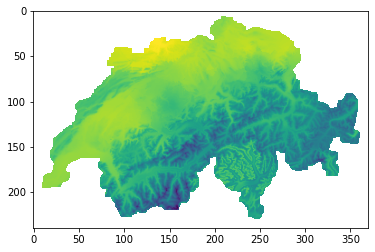

In [392]:
# I can plot this raster using numpy's pyplot
# but the y axis needs to be flipped
# plt.imshow(tas_0)
plt.imshow(np.flip(tas_0, 0))

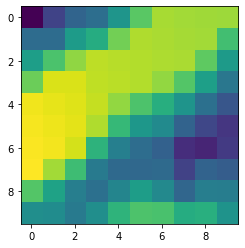

In [393]:
# You can subset a specific area by passing ranges in [ ]
plt.imshow(np.flip(tabs_2012.variables["TabsD"][2,40:50,100:110], 0))

In [394]:
tabs_2012["/TabsD/"]

<class 'netCDF4._netCDF4.Variable'>
float32 TabsD(time, N, E)
    units: degree
    _FillValue: -999.99
    grid_mapping: swiss_lv95_coordinates
    coordinates: lon lat
    long_name: daily mean temperature
    grid_name: ch01r.swiss.lv95
    version: v1.2
    prod_date: 2021-09-08 04:42:56
unlimited dimensions: time
current shape = (366, 240, 370)
filling on


What I need to calculate is the following (pseudocode):

```
for years in 2031-2040:
    for days in 30.09.year-01.04.(year+1):
        ((tas-10)+(tas_max-10))/2*1.045
        
```

Variable `time` is in the `units`: `number of days since 1900-1-1 00:00:00`


In [395]:
times_dict = {x:[get_days(x, 9, 30, 12), get_days(x+1, 4,1,12)] for x in range(2012, 2022)}

times_dict = {}

for year in range(2012, 2021):
    year_dict = {}
    year_dict["this"] = [get_days(year, 9, 30, 0), get_days(year, 12, 31, 0)]
    year_dict["next"] = [get_days(year+1, 1, 1, 0), get_days(year+1, 4, 1, 0)]
    times_dict[year] = year_dict
    
times_dict

{2012: {'this': [41180.0, 41272.0], 'next': [41273.0, 41363.0]},
 2013: {'this': [41545.0, 41637.0], 'next': [41638.0, 41728.0]},
 2014: {'this': [41910.0, 42002.0], 'next': [42003.0, 42093.0]},
 2015: {'this': [42275.0, 42367.0], 'next': [42368.0, 42459.0]},
 2016: {'this': [42641.0, 42733.0], 'next': [42734.0, 42824.0]},
 2017: {'this': [43006.0, 43098.0], 'next': [43099.0, 43189.0]},
 2018: {'this': [43371.0, 43463.0], 'next': [43464.0, 43554.0]},
 2019: {'this': [43736.0, 43828.0], 'next': [43829.0, 43920.0]},
 2020: {'this': [44102.0, 44194.0], 'next': [44195.0, 44285.0]}}

In [396]:
# Import the kanton of luzern ....
kantonsgrenze = gpd.read_file("../data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/", layer = "TLM_KANTONSGEBIET").query("NAME == 'Luzern'") # fiona.listlayers("data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/")

# buffer it with 2km, transform it to wsg84 and get the bounding box
kanton_bounds = kantonsgrenze.buffer(2000).bounds
kanton_bounds

,minx,miny,maxx,maxy
8,2.628130e+06,1.178571e+06,2.683764e+06,1.239690e+06


In [397]:
E_bounds = [kanton_bounds["minx"].iloc[0], kanton_bounds["maxx"].iloc[0]]
N_bounds = [kanton_bounds["miny"].iloc[0], kanton_bounds["maxy"].iloc[0]]


N_bounds

[1178570.734462117, 1239689.9772588543]

In [398]:
nc_per_year

{2012: {'thisMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201201010000_201212310000.nc',
  'nextMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'thisMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201201010000_201212310000.nc',
  'nextMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201301010000_201312310000.nc'},
 2013: {'thisMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'nextMean': '../data/historische_daten/TabsD_2001_2021_LV95/TabsD_ch01r.swiss.lv95_201401010000_201412310000.nc',
  'thisMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201301010000_201312310000.nc',
  'nextMax': '../data/historische_daten/TmaxD_11_21_ch01r.swiss.lv95/TmaxD_ch01r.swiss.lv95_201401010000_201412310000.nc'},
 2014: {'thisMean': '../data/h

In [485]:
E_bounds

[2628129.7065847395, 2683763.807443407]

In [531]:
# https://gis.stackexchange.com/q/37238/40929
E_idx = [index_from_value(E, x) for x in E_bounds]
N_idx = [index_from_value(N, x) for x in N_bounds]


all_years = []
for year, date_idxs in times_dict.items():
    print("year",year)
    thisMean = netCDF4.Dataset(nc_per_year[year]["thisMean"])
    thisMax = netCDF4.Dataset(nc_per_year[year]["thisMax"])
    nextMean = netCDF4.Dataset(nc_per_year[year]["nextMean"])
    nextMax = netCDF4.Dataset(nc_per_year[year]["nextMax"])
    
    # this years data (01-09 to 31.12)
    times = thisMean["time"][:]
    this_start_date_idx = index_from_value(times, date_idxs["this"][0])
    this_end_date_idx = index_from_value(times, date_idxs["this"][1])
    
    this_mean_subset = thisMean["TabsD"][this_start_date_idx:this_end_date_idx,N_idx[0]:N_idx[1], E_idx[0]:E_idx[1]]
    this_max_subset = thisMax["TmaxD"][this_start_date_idx:this_end_date_idx,N_idx[0]:N_idx[1], E_idx[0]:E_idx[1]]
    
    # this years data (01-01 to 01.04)
    times = nextMean["time"][:]
    next_start_date_idx = index_from_value(times, date_idxs["next"][0])
    next_end_date_idx = index_from_value(times, date_idxs["next"][1])
    
    next_mean_subset = nextMean["TabsD"][next_start_date_idx:next_end_date_idx, N_idx[0]:N_idx[1], E_idx[0]:E_idx[1]]
    next_max_subset = nextMax["TmaxD"][next_start_date_idx:next_end_date_idx, N_idx[0]:N_idx[1], E_idx[0]:E_idx[1]]
    

    # the magic happens here:
    this_sum = np.sum(((this_mean_subset-10)+(this_max_subset-10))/2*1.045,axis = 0) # hugglin index for 30.9 - 31.12 
    next_sum = np.sum(((next_mean_subset-10)+(next_max_subset-10))/2*1.045,axis = 0) # hugglin index for 01.1 - 01.04
    
    # sum of the two above
    res = np.sum([this_sum, next_sum], axis = 0)
    
    all_years.append(res)

    # xmin,ymin,xmax,ymax = E[E_idx][0], N[N_idx][0], E[E_idx][1],  N[N_idx][1]
    xmin,ymin,xmax,ymax = E_bounds[0], N_bounds[0], E_bounds[1], N_bounds[1] # not tested

    
    nrows,ncols = np.shape(res)

    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    print((xres))

    geotransform=(xmin, xres, 0,ymax, 0, -yres) 
    
    subdir = "../output/historic/"
    os.makedirs(subdir, exist_ok=True)

    crs = CRS.from_epsg(2056)
    transform = from_origin(xmin, ymax, 1000, 1000)
    with rasterio.open(subdir+str(year)+".tif",
                   "w", 
                   driver = "GTiff", 
                   height=res.shape[0], 
                   width = res.shape[1], 
                   count = 1, 
                   dtype = res.dtype,
                   transform = transform,
                   crs = crs, masked = True
                  ) as dst:
        dst.write(res, 1)
    
    del res

crs = CRS.from_epsg(2056)
transform = from_origin(xmin, ymax, 1000, 1000)
with rasterio.open(subdir+"Mean.tif",
                   "w", 
                   driver = "GTiff", 
                   height=all_years_mean.shape[0], 
                   width = all_years_mean.shape[1], 
                   count = 1, 
                   dtype = all_years_mean.dtype,
                   transform = transform,
                   crs = crs, masked = True
                  ) as dst:
    dst.write(all_years_mean, 1)
    
del all_years_mean


year 2012
1000.0
year 2013
1000.0
year 2014
1000.0
year 2015
1000.0
year 2016
1000.0
year 2017
1000.0
year 2018
1000.0
year 2019
1000.0
year 2020
1000.0


In [489]:
import os
import subprocess

import numpy as np
import rasterio
from rasterio import transform
from rasterio.warp import reproject, Resampling


tiffname = 'example.tif'

with rasterio.Env():

    # Consider a 512 x 512 raster centered on 0 degrees E and 0 degrees N
    # with each pixel covering 15".
    rows, cols = src_shape = (512, 512)
    dpp = 1.0/240  # decimal degrees per pixel
    west, south, east, north = -cols*dpp/2, -rows*dpp/2, cols*dpp/2, rows*dpp/2
    src_transform = transform.from_bounds(west, south, east, north, cols, rows)
    src_crs = {'init': 'EPSG:4326'}
    source = np.ones(src_shape, np.uint8)*255

    # Prepare to reproject this rasters to a 1024 x 1024 dataset in
    # Web Mercator (EPSG:3857) with origin at -237481.5, 237536.4.
    dst_shape = (1024, 1024)
    dst_transform = transform.from_origin(-237481.5, 237536.4, 425.0, 425.0)
    dst_crs = {'init': 'EPSG:3857'}
    destination = np.zeros(dst_shape, np.uint8)

    reproject(
        source,
        destination,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)

    # Assert that the destination is only partly filled.
    assert destination.any()
    assert not destination.all()

    # Write it out to a file.
    with rasterio.open(
            tiffname,
            'w',
            driver='GTiff',
            width=dst_shape[1],
            height=dst_shape[0],
            count=1,
            dtype=np.uint8,
            nodata=0,
            transform=dst_transform,
            crs=dst_crs) as dst:
        dst.write(destination, indexes=1)

info = subprocess.call(['open', tiffname])

FileNotFoundError: [Errno 2] No such file or directory: 'open'

In [495]:
not destination.all()

True